<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [139]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js') 

<IPython.core.display.Javascript object>

# Problem Statement

This report presents a interpretable model to predict monetary value of a customer over a prediod of time in the future based on their history in e-commerce business. These predictions can be used by the sales team to prioritize customers with higher value for the business. The data is obtained from a [public repository](https://www.kaggle.com/olistbr/brazilian-ecommerce) where information about the data can be found.

# Data Cleaning

In [2]:
# frequently used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date

## Order Database

In [3]:
# read data and show its high-level information
order_df = pd.read_csv('olist_orders_dataset.csv')
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
# drop irrelevant columns
order_df.drop(['order_status',
               'order_delivered_carrier_date',
               'order_approved_at'], axis='columns', inplace=True)
order_df.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [5]:
# assign datetime data type for date/time columns  
for column in ['order_purchase_timestamp',
               'order_delivered_customer_date',
               'order_estimated_delivery_date']:
    order_df[column] = pd.to_datetime(order_df[column])
order_df.dtypes

order_id                                 object
customer_id                              object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [6]:
# duplicate rows of dataframe
order_df[order_df.duplicated()]

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date


In [7]:
# head of values
order_df.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26


## Payment Database

In [8]:
# read data and show its high-level information
payment_df = pd.read_csv('olist_order_payments_dataset.csv')
payment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
order_id                103886 non-null object
payment_sequential      103886 non-null int64
payment_type            103886 non-null object
payment_installments    103886 non-null int64
payment_value           103886 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [9]:
payment_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [10]:
# duplicate rows of dataframe
payment_df[payment_df.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [11]:
# head of values
payment_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


## Customer Database

In [12]:
# read data and show its high-level information
customer_df = pd.read_csv('olist_customers_dataset.csv')
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [13]:
# drop irrelevant columns
customer_df.drop(['customer_zip_code_prefix',
                  'customer_city'], axis='columns', inplace=True)
customer_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_state'], dtype='object')

In [14]:
# duplicate rows of dataframe
customer_df[customer_df.duplicated()]

,customer_id,customer_unique_id,customer_state


In [15]:
# head of values
customer_df.head()

,customer_id,customer_unique_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP


## Review Database

In [16]:
# read data and show its high-level information
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null object
review_answer_timestamp    100000 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [17]:
# drop irrelevant columns
review_df.drop(['review_id',
                'review_creation_date',
                'review_answer_timestamp'], axis='columns', inplace=True)
review_df.columns

Index(['order_id', 'review_score', 'review_comment_title',
       'review_comment_message'],
      dtype='object')

In [18]:
# duplicate rows of dataframe
review_df[review_df.duplicated()]

,order_id,review_score,review_comment_title,review_comment_message
1128,5040757d4e06a4be96d3827b860b4e7c,5,NaN,NaN
3127,cf73e2cb1f4a9480ed70c154da3d954a,5,NaN,NaN
9128,c7cfea0c153e6382e32e84c2a9dd7d2e,5,NaN,NaN
10652,0715dfcf2383aa72c181d8b47f6cb589,5,NaN,NaN
12682,f63a31c3349b87273468ff7e66852056,5,NaN,NaN
...,...,...,...,...
99332,157de1652c032429a625d034be79eeeb,5,NaN,NaN
99380,19fe6cd13dca5943f17abd2c37c46abd,5,NaN,NaN
99422,1de86d094f7dd41cca13d246d3b7fd07,5,NaN,NaN
99445,baed56f3eda9223b74c6cf175f05678e,5,NaN,NaN


In [19]:
# head of values
review_df.head()

,order_id,review_score,review_comment_title,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN
3,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...


## Item Database

In [20]:
# read data and show its high-level information
item_df = pd.read_csv('olist_order_items_dataset.csv')
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null object
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [21]:
# drop irrelevant columns
item_df.drop(['seller_id',
              'shipping_limit_date',
              'price',
              'freight_value',
              'order_item_id'], axis='columns', inplace=True)
item_df.columns

Index(['order_id', 'product_id'], dtype='object')

In [22]:
# duplicate rows of dataframe
item_df[item_df.duplicated()]

,order_id,product_id
14,0008288aa423d2a3f00fcb17cd7d8719,368c6c730842d78016ad823897a372db
33,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a
34,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a
43,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2
44,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2
...,...,...
112617,ffecd5a79a0084f6a592288c67e3c298,50fd2b788dc166edd20512370dac54df
112635,fff8287bbae429a99bb7e8c21d151c41,bee2e070c39f3dd2f6883a17a5f0da45
112641,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73
112642,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73


In [23]:
# head of values
item_df.head()

,order_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089


## Product Database

In [24]:
# read data and show its high-level information
product_df = pd.read_csv('olist_products_dataset.csv')
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [25]:
# drop irrelevant columns
product_df.drop(['product_name_lenght',
                 'product_description_lenght', 
                 'product_photos_qty', 
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'product_width_cm'], axis='columns', inplace=True)
product_df.columns

Index(['product_id', 'product_category_name'], dtype='object')

In [26]:
product_df.fillna('other', inplace=True)
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 2 columns):
product_id               32951 non-null object
product_category_name    32951 non-null object
dtypes: object(2)
memory usage: 515.0+ KB


In [27]:
product_df[product_df.duplicated()]

,product_id,product_category_name


In [28]:
# head of values
product_df.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


## Translation Database

In [29]:
# read data and show its high-level information
translation_df = pd.read_csv('product_category_name_translation.csv')
translation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
product_category_name            71 non-null object
product_category_name_english    71 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [30]:
# duplicate rows of dataframe
translation_df[product_df.duplicated()]

,product_category_name,product_category_name_english


In [31]:
# head of values
translation_df.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


## Database Joins

In [32]:
po_df = pd.merge(payment_df, order_df, how='left', on='order_id')
po_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 9 columns):
order_id                         103886 non-null object
payment_sequential               103886 non-null int64
payment_type                     103886 non-null object
payment_installments             103886 non-null int64
payment_value                    103886 non-null float64
customer_id                      103886 non-null object
order_purchase_timestamp         103886 non-null datetime64[ns]
order_delivered_customer_date    100754 non-null datetime64[ns]
order_estimated_delivery_date    103886 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(2), object(3)
memory usage: 7.9+ MB


In [33]:
poc_df = pd.merge(po_df, customer_df, how='left', on='customer_id')
poc_df.drop('customer_id', axis='columns', inplace=True)
poc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 10 columns):
order_id                         103886 non-null object
payment_sequential               103886 non-null int64
payment_type                     103886 non-null object
payment_installments             103886 non-null int64
payment_value                    103886 non-null float64
order_purchase_timestamp         103886 non-null datetime64[ns]
order_delivered_customer_date    100754 non-null datetime64[ns]
order_estimated_delivery_date    103886 non-null datetime64[ns]
customer_unique_id               103886 non-null object
customer_state                   103886 non-null object
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 8.7+ MB


In [34]:
poci_df = pd.merge(poc_df, item_df, how='right', on='order_id')
poci_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 11 columns):
order_id                         117604 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_id                       117604 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


In [35]:
poci_df.drop(poci_df[poci_df.payment_value.isnull()].index, axis='index', inplace=True)
poci_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 11 columns):
order_id                         117601 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_id                       117601 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


In [36]:
pocip_df = pd.merge(poci_df, product_df, how='left', on='product_id')
pocip_df.drop('product_id', axis='columns', inplace=True)
pocip_df.info()
pocip_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 11 columns):
order_id                         117601 non-null object
payment_sequential               117601 non-null float64
payment_type                     117601 non-null object
payment_installments             117601 non-null float64
payment_value                    117601 non-null float64
order_purchase_timestamp         117601 non-null datetime64[ns]
order_delivered_customer_date    115034 non-null datetime64[ns]
order_estimated_delivery_date    117601 non-null datetime64[ns]
customer_unique_id               117601 non-null object
customer_state                   117601 non-null object
product_category_name            117601 non-null object
dtypes: datetime64[ns](3), float64(3), object(5)
memory usage: 10.8+ MB


,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,product_category_name
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,2018-04-25 22:01:49,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,MG,casa_construcao
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,2018-06-26 11:01:38,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,SP,automotivo
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,2017-12-12 11:19:55,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,SP,perfumaria
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,2017-12-06 12:04:06,2017-12-21 01:35:51,2018-01-04,87695ed086ebd36f20404c82d20fca87,MG,cama_mesa_banho
4,42fdf880ba16b47b59251dd489d4441a,1.0,credit_card,2.0,128.45,2018-05-21 13:59:17,2018-06-01 21:44:53,2018-06-13,4291db0da71914754618cd789aebcd56,SP,cama_mesa_banho


In [37]:
pocipr_df = pd.merge(pocip_df, review_df, how='right', on='order_id')
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119094 entries, 0 to 119093
Data columns (total 14 columns):
order_id                         119094 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     119094 non-null int64
review_comment_title             14181 non-null object
review_comment_message           51209 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.6+ MB

In [38]:
pocipr_df.drop(pocipr_df[pocipr_df.payment_value.isnull()].index, axis='index', inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     118315 non-null int64
review_comment_title             14089 non-null object
review_comment_message           50665 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.5+ MB

In [39]:
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     118315 non-null int64
review_comment_title             14089 non-null object
review_comment_message           50665 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.5+ MB

In [40]:
pocipr_df.fillna(pocipr_df.median(), inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
product_category_name            118315 non-null object
review_score                     118315 non-null int64
review_comment_title             14089 non-null object
review_comment_message           50665 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.5+ MB

In [41]:
pocipr_df = pd.merge(pocipr_df, translation_df, how='left', on='product_category_name')
pocipr_df.drop('product_category_name', axis='columns', inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
review_score                     118315 non-null int64
review_comment_title             14089 non-null object
review_comment_message           50665 non-null object
product_category_name_english    116581 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.5+ MB

In [42]:
pocipr_df.product_category_name_english.fillna('other', inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
order_purchase_timestamp         118315 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
review_score                     118315 non-null int64
review_comment_title             14089 non-null object
review_comment_message           50665 non-null object
product_category_name_english    118315 non-null object
dtypes: datetime64[ns](3), float64(3), int64(1), object(7)
memory usage: 13.5+ MB

# Exploratory Data Analytics - Stage 1

In [119]:
pocipr_df.payment_type.nunique()

4

In [120]:
pocipr_df.product_category_name_english.nunique()

72

In [121]:
pocipr_df.customer_state.nunique()

27

# Feature Engineering

In [43]:
# replace comment with 1 or 0 depending on existence 
for columns in ['review_comment_title', 'review_comment_message']:
    # replace present values with 1
    pocipr_df.loc[pocipr_df[columns].notnull(), columns] = 1
    # replace null values with 0
    pocipr_df.loc[pocipr_df[columns].isna(), columns] = 0

In [44]:
# create features and drop columns they were built on
pocipr_df['delay'] = (pocipr_df.order_delivered_customer_date - pocipr_df.order_estimated_delivery_date).dt.days
pocipr_df['purchase_date'] = pocipr_df['order_purchase_timestamp'].dt.date
pocipr_df.drop(['order_purchase_timestamp',
                'order_delivered_customer_date',
                'order_estimated_delivery_date'], axis='columns', inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
product_category_name_english    118315 non-null object
delay                            115727 non-null float64
purchase_date                    118315 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 12.6+ MB


In [46]:
pocipr_df.delay.fillna(pocipr_df.delay.median(), inplace=True)
pocipr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
order_id                         118315 non-null object
payment_sequential               118315 non-null float64
payment_type                     118315 non-null object
payment_installments             118315 non-null float64
payment_value                    118315 non-null float64
customer_unique_id               118315 non-null object
customer_state                   118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
product_category_name_english    118315 non-null object
delay                            118315 non-null float64
purchase_date                    118315 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 12.6+ MB


In [47]:
# seperate feature and target transaction histories
pocipr_df1 = pocipr_df[(date(2016,10,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,4,1))]
pocipr_df2 = pocipr_df[(date(2018,4,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,10,1))]
pocipr_df2 = pocipr_df2[['customer_unique_id', 'payment_value']]

In [48]:
# group features by customer with approperiate metric
cust_pocipr_df1 = pocipr_df1.groupby('customer_unique_id').agg({'purchase_date': lambda x: min((max(pocipr_df1.purchase_date)-x).dt.days),  
                                                    'order_id': 'count',
                                                    'payment_value': 'sum',
                                                    'delay': 'mean',
                                                    'payment_installments': 'mean',
                                                    'review_score': 'mean',
                                                    'review_comment_title': 'mean',
                                                    'review_comment_message': 'mean',
                                                    'payment_type': lambda x: x.value_counts().index[0],
                                                    'product_category_name_english': lambda x: x.value_counts().index[0],
                                                    'customer_state': lambda x: x.value_counts().index[0]})
cust_pocipr_df1.columns = ['recency', 'frequency', 'monetary', 'delay', 'installments', 'review_score',
                           'comment_title', 'comment_message', 'pop_payment_type', 'pop_category', 'customer_state']
cust_pocipr_df1.columns

In [50]:
cust_pocipr_df1.head()

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type,pop_category,customer_state
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,386,1,86.22,-2.0,8.0,3.0,0.0,0.0,credit_card,stationery,SC
0000f6ccb0745a6a4b88665a16c9f078,170,1,43.62,-12.0,4.0,4.0,0.0,1.0,credit_card,telephony,PA
0004aac84e0df4da2b147fca70cf8255,137,1,196.89,-8.0,6.0,5.0,0.0,0.0,credit_card,telephony,SP
00053a61a98854899e70ed204dd4bafe,31,2,838.36,-10.0,3.0,1.0,0.0,1.0,credit_card,sports_leisure,PR
0005e1862207bf6ccc02e4228effd9a0,392,1,150.12,-28.0,3.0,4.0,0.0,0.0,credit_card,fashion_bags_accessories,RJ


In [52]:
# create dataframe fed to algorithms
feature_df = pd.get_dummies(cust_pocipr_df1)
target_df = pocipr_df2.groupby('customer_unique_id').agg({'payment_value':'sum'})
df = pd.merge(feature_df, target_df, on='customer_unique_id')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 626 entries, 004b45ec5c64187465168251cd1c9c2f to fe81bb32c243a86b2f86fbf053fe6140
Columns: 112 entries, recency to payment_value
dtypes: float64(7), int64(2), uint8(103)
memory usage: 111.9+ KB


,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.0,1.0,1.0,0.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,49.85
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.0,2.0,3.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,80.32
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.0,5.0,4.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,1,0,340.07
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.0,9.0,4.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,1,0,473.58
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.0,3.0,4.0,0.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,271.64


In [53]:
# drop columns constant across common customers
df = df.loc[:, (df != df.iloc[0]).any()] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 626 entries, 004b45ec5c64187465168251cd1c9c2f to fe81bb32c243a86b2f86fbf053fe6140
Data columns (total 82 columns):
recency                                         626 non-null int64
frequency                                       626 non-null int64
monetary                                        626 non-null float64
delay                                           626 non-null float64
installments                                    626 non-null float64
review_score                                    626 non-null float64
comment_title                                   626 non-null float64
comment_message                                 626 non-null float64
pop_payment_type_boleto                         626 non-null uint8
pop_payment_type_credit_card                    626 non-null uint8
pop_payment_type_debit_card                     626 non-null uint8
pop_payment_type_voucher                        626 non-null uint8
pop_category_air_conditi

# Exploratory Data Analytics - Stage 2

In [56]:
pocipr_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_state,review_score,review_comment_title,review_comment_message,product_category_name_english,delay,purchase_date
0,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33,708ab75d2a007f0564aedd11139c7708,MG,1,1,1,home_construction,-13.0,2018-04-25
1,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39,a8b9d3a27068454b1c98cc67d4e31e6f,SP,5,0,0,auto,-17.0,2018-06-26
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71,6f70c0b2f7552832ba46eb57b1c5651e,SP,5,0,1,perfumery,-17.0,2017-12-12
3,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,5,0,0,bed_bath_table,-14.0,2017-12-06
4,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78,87695ed086ebd36f20404c82d20fca87,MG,5,0,0,bed_bath_table,-14.0,2017-12-06


In [57]:
review_df.nunique()

order_id                  99441
review_score                  5
review_comment_title       4600
review_comment_message    36921
dtype: int64

In [58]:
payment_df['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

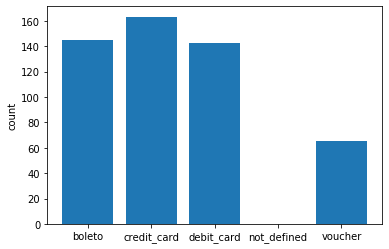

In [133]:
plt.bar(payment_df.groupby('payment_type').mean().index, 
        payment_df.groupby('payment_type').mean()['payment_value'])
plt.ylabel('count');

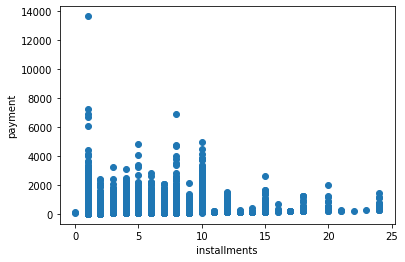

In [129]:
plt.scatter(payment_df.payment_installments, payment_df.payment_value)
plt.xlabel('installments')
plt.ylabel('payment');

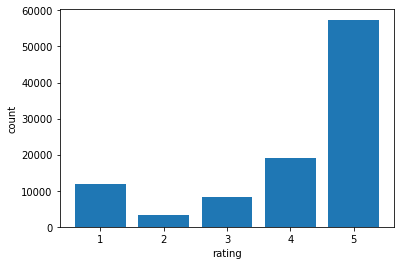

In [132]:
plt.bar(review_df.review_score.value_counts().index, review_df.review_score.value_counts().values)
plt.xlabel('rating')
plt.ylabel('count');

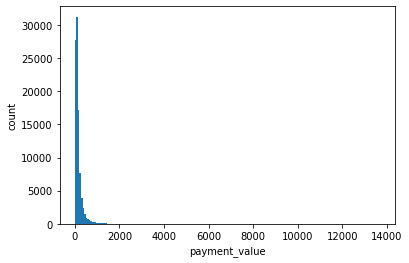

In [62]:
plt.hist(poc_df.groupby('customer_unique_id')['payment_value'].sum(), bins=200)
plt.xlabel('payment_value')
plt.ylabel('count');

Text(0, 0.5, 'average payment per order')

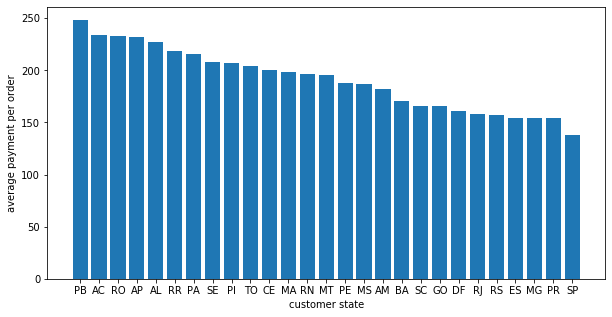

In [63]:
state_pay_series = poc_df.groupby('customer_state').sum()['payment_value']/poc_df.groupby('customer_state').count()['payment_value']
state_pay_series.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(10,5))
plt.bar(state_pay_series.index, state_pay_series);
plt.xlabel('customer state')
plt.ylabel('average payment per order')

<BarContainer object of 74 artists>

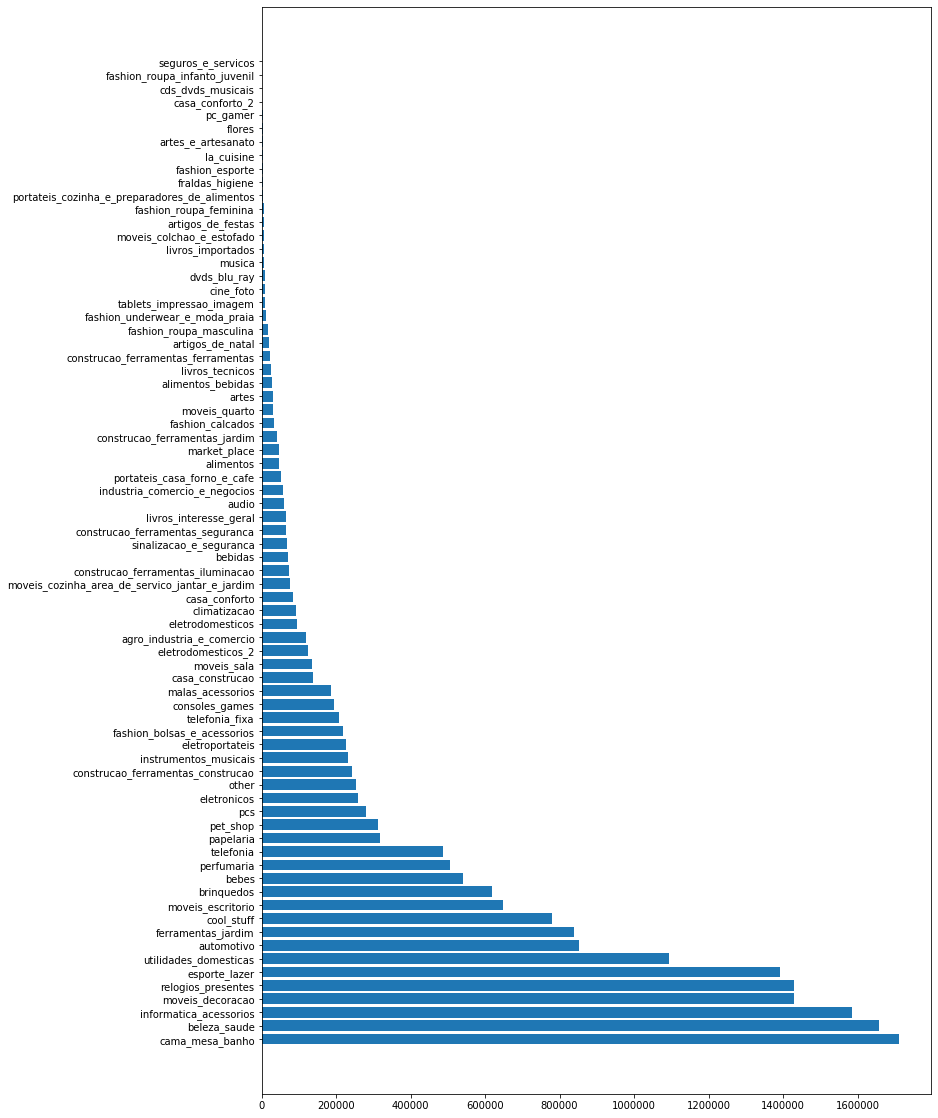

In [64]:
payment_by_category = pocip_df.groupby('product_category_name')['payment_value'].sum()
payment_by_category.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12,20))
plt.barh(payment_by_category.index, payment_by_category)

Text(0, 0.5, 'payment')

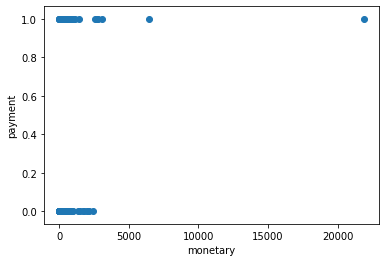

In [135]:
plt.scatter(df.monetary, df.payment_value)
plt.xlabel('monetary')
plt.ylabel('payment');

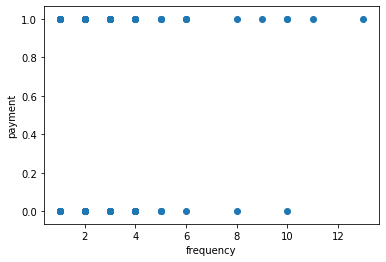

In [136]:
plt.scatter(df.frequency, df.payment_value)
plt.xlabel('frequency')
plt.ylabel('payment');

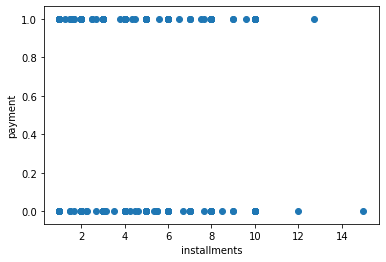

In [138]:
plt.scatter(df.installments, df.payment_value)
plt.xlabel('installments')
plt.ylabel('payment');

# Corrlation Analysis

In [65]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i], 
    np.abs(stats.pearsonr(df[df.columns[i]], df.payment_value)[0]),
    stats.pearsonr(df[df.columns[i]], df.payment_value)[0],
    stats.pearsonr(df[df.columns[i]], df.payment_value)[1]])
    
corr_df = pd.DataFrame(corr_array, columns = ['feature', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df.reset_index(drop = True, inplace = True)
corr_df

,feature,abs_corr,corr,p_value
0,monetary,0.384817,0.384817,1.580540e-23
1,frequency,0.234428,0.234428,2.910304e-09
2,pop_category_watches_gifts,0.149191,0.149191,1.794787e-04
3,pop_category_office_furniture,0.143431,0.143431,3.180792e-04
4,pop_category_consoles_games,0.075049,0.075049,6.057150e-02
...,...,...,...,...
76,comment_title,0.005605,-0.005605,8.886970e-01
77,customer_state_CE,0.002225,-0.002225,9.556867e-01
78,pop_category_audio,0.001493,-0.001493,9.702540e-01
79,pop_category_cool_stuff,0.000204,0.000204,9.959356e-01


# Logistic Regression

## Value-based

Text(0.5, 0, 'normalized coefficient')

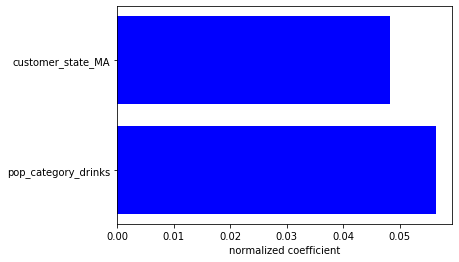

In [109]:
# seperate target from features
X = df.iloc[:,:-1]
y = df.iloc[:,-1].reset_index(drop=True)

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit OLS function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
lr = sm.OLS(y, X_withconstant).fit()
#display(lr.summary())

# table of significant coefficinets sorted by absolute value
coef_table = lr.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|t|'] = coef_df['P>|t|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|t|'] <= 0.05]

# bar chart of feature coefficients
plt.barh(coefs_by_mag[''], coefs_by_mag['coef'], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')

## Quartile-based

In [84]:
df_q4 = df
df_q4.payment_value = pd.qcut(df_q4.payment_value, 4, labels=[1, 2, 3, 4])
df_q4

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.000000,1.0,1.000000,0.0,1.000000,1,0,...,0,0,0,0,0,0,0,0,0,1
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.000000,2.0,3.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,2
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.000000,5.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,4
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.000000,9.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,4
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.000000,3.0,4.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc19fe9ac733e36ff8227c29435c2030,430,2,60.86,-30.000000,1.0,5.000000,0.0,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,2
fcd0ab79592faab19e2bf386cf69fbcd,414,1,45.95,-27.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,1,0,0,0,0,1
fd8ccc89be43894d2553494c71a61fd8,18,3,206.01,-22.000000,1.0,4.666667,0.0,1.000000,0,1,...,0,1,0,0,0,0,0,0,0,4


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.607606038851795
            Iterations: 69
            Function evaluations: 70
            Gradient evaluations: 69


Text(0.5, 0, 'normalized coefficient')

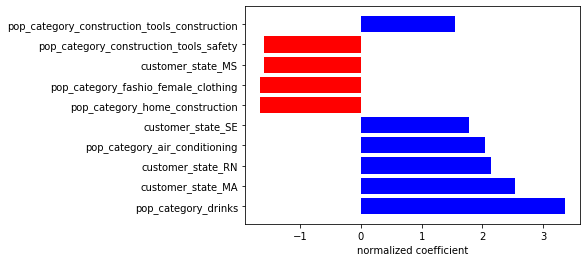

In [110]:
# seperate target from features
X = df_q4.iloc[:,:-1]
y = df_q4.iloc[:,-1].reset_index(drop=True)

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit OLS function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
lr = sm.Logit(y, X_withconstant).fit_regularized()
#display(lr.summary())

# table of significant coefficinets sorted by absolute value
coef_table = lr.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
#coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
bar_colors = np.where(bar_heights>0, 'blue', 'red')
plt.barh(coefs_by_mag[''][:10], coefs_by_mag['coef'][:10], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')

## Binary Classification

In [88]:
df_q2 = df
df_q2.payment_value = pd.qcut(df_q2.payment_value, 2, labels=[0, 1])
df_q2

,recency,frequency,monetary,delay,installments,review_score,comment_title,comment_message,pop_payment_type_boleto,pop_payment_type_credit_card,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_value
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
004b45ec5c64187465168251cd1c9c2f,211,1,97.87,-13.000000,1.0,1.000000,0.0,1.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
011575986092c30523ecb71ff10cb473,42,1,134.58,-5.000000,2.0,3.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
012452d40dafae4df401bced74cdb490,286,1,155.26,-6.000000,5.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,1
0178b244a5c281fb2ade54038dd4b161,325,1,102.03,-11.000000,9.0,4.000000,0.0,0.000000,0,1,...,0,0,0,0,0,0,0,1,0,1
01f2285f85a1c603eb7ef755ad311769,336,1,191.40,-15.000000,3.0,4.000000,0.0,1.000000,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc19fe9ac733e36ff8227c29435c2030,430,2,60.86,-30.000000,1.0,5.000000,0.0,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
fcd0ab79592faab19e2bf386cf69fbcd,414,1,45.95,-27.000000,1.0,5.000000,0.0,0.000000,0,1,...,0,0,0,0,1,0,0,0,0,0
fd8ccc89be43894d2553494c71a61fd8,18,3,206.01,-22.000000,1.0,4.666667,0.0,1.000000,0,1,...,0,1,0,0,0,0,0,0,0,1


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.607606038851795
            Iterations: 69
            Function evaluations: 70
            Gradient evaluations: 69


Text(0.5, 0, 'normalized coefficient')

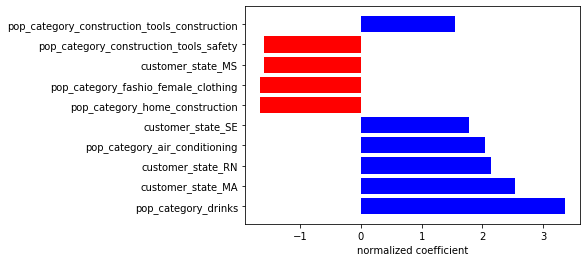

In [111]:
# seperate target from features
X = df_q2[df_q2.columns[:-1]]
y = df_q2[df_q2.columns[-1]].reset_index(drop=True)

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit OLS function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
lr = sm.Logit(y, X_withconstant).fit_regularized()
#display(lr.summary())

# table of significant coefficinets sorted by absolute value
coef_table = lr.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
#coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
bar_colors = np.where(bar_heights>0, 'blue', 'red')
plt.barh(coefs_by_mag[''][:10], coefs_by_mag['coef'][:10], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')

# Hyperparameter Optimization

In [98]:
# split data to train and test sets
from sklearn.model_selection import train_test_split
X = df_q2.iloc[:,:-1]
y = df_q2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

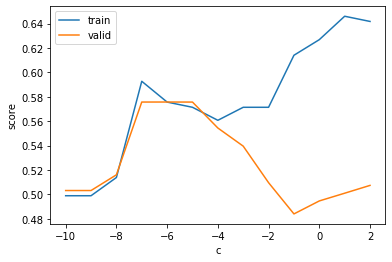

In [101]:
# hyperparameter optimization with cross validation score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

valid_scores = []
train_scores = []
for n in range(-10,3):
    lr = LogisticRegression(C=10**n, random_state=42)
    lr.fit(X_train, y_train)
    train_scores.append(lr.score(X_train, y_train))
    valid_scores.append(np.mean(cross_val_score(lr, X_train, y_train, cv = 5)))
    
plt.plot(range(-10,3), train_scores, label='train')
plt.plot(range(-10,3), valid_scores, label='valid')
plt.legend()
plt.xlabel('c')
plt.ylabel('score');

In [102]:
lr = LogisticRegression(C=10**-5, random_state=42)
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

Train Accuracy:  0.5714285714285714
Test Accuracy:  0.5859872611464968


# Model Evaluation

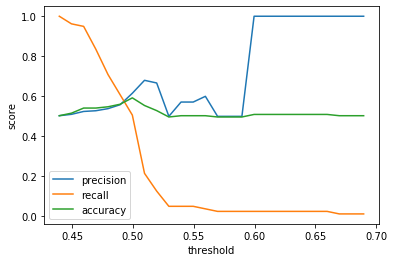

In [104]:
# probabilities of positive predictions
y_proba = lr.predict_proba(X_test)[:,1]

# accuracy metric functions from scikit learn
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# list of accuracy metrics for each threshold value
precision_list = []
recall_list = []
accuracy_list = []
threshold_list = np.arange(y_proba.min(), y_proba.max(), 0.01)
for threshold in threshold_list:
    y_threshold = np.where(y_proba >= threshold, 1, 0)
    precision_list.append(precision_score(y_test, y_threshold))
    recall_list.append(recall_score(y_test, y_threshold))
    accuracy_list.append(accuracy_score(y_test, y_threshold))

# plot all accuracy metrics versus threshold in one plot
plt.plot(threshold_list, precision_list, label='precision')
plt.plot(threshold_list, recall_list, label='recall')
plt.plot(threshold_list, accuracy_list, label='accuracy')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()

# Tailoring Predictions to Sales Strategie

||Base<br />Strat.|Low<br />Inv.|High<br />Inv.|
|-|-|-|-|
|Precision|62%|68%|54%|
|Recall|51%|22%|71%|
|Accuracy|59%|55%|54%|